In [27]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
import pandas as pd 
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio 
from plotly.subplots import make_subplots
from scipy.stats import norm
from scipy.stats import beta
import ipywidgets as widgets
from IPython.display import display

# Set path to fugures 
fig_path = os.path.join(os.getcwd() + '/Figures')
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Set style to seaborn 
sns.set(style="whitegrid")

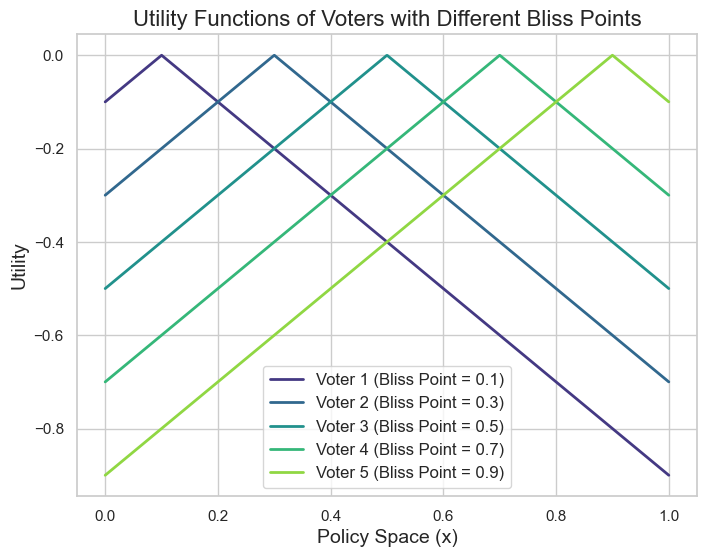

In [28]:
# Set policy space 
x = np.linspace(0, 1, 1000)

# Define utility function as absolute value of difference between x and bliss point 
def utility_function(x, bliss_point):
    return np.abs(x - bliss_point)*(-1)   

# Define bliss points for five illustrative voters 
bliss_points = [0.1, 0.3, 0.5, 0.7, 0.9]

# Use the viridis palette for a smooth gradient
viridis_colors = sns.color_palette("viridis", len(bliss_points))

# Create labels for each voter based on their bliss point
labels = [
    'Voter 1 (Bliss Point = 0.1)',
    'Voter 2 (Bliss Point = 0.3)',
    'Voter 3 (Bliss Point = 0.5)',
    'Voter 4 (Bliss Point = 0.7)',
    'Voter 5 (Bliss Point = 0.9)',
]

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 6))
# Plot each voter's utility function
for bp, label, color in zip(bliss_points, labels, viridis_colors):
    ax.plot(x, utility_function(x, bp), label=label, linewidth=2, color=color)

# Add labels and title
ax.set_xlabel('Policy Space (x)', fontsize=14)
ax.set_ylabel('Utility', fontsize=14)
ax.set_title('Utility Functions of Voters with Different Bliss Points', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True)
plt.savefig(os.path.join(fig_path, 'downs_utility_functions.png'), dpi=300, bbox_inches='tight')

In [29]:
# Define voter distribution with safe sampling and smooth CDF
def get_voter_distribution(dist_type, n=5000, noise=1e-6):
    if dist_type == 'Normal':
        voters = np.random.normal(0.5, 0.15, n)
    elif dist_type == 'Bimodal':
        left = np.random.normal(0.35, 0.08, n // 2)
        right = np.random.normal(0.65, 0.08, n // 2)
        voters = np.concatenate([left, right])
    elif dist_type == 'Skewed':
        voters = beta.rvs(a=2, b=5, size=n)
    else:
        raise ValueError("Unsupported distribution.")

    # Enforce domain and uniqueness (for strictly increasing empirical CDF)
    voters = np.clip(voters, 0, 1) + np.random.uniform(0, noise, n)
    voters.sort()
    return voters

# Main interactive update function
def update_plot(dist_type='Normal', pos_A=0.2, pos_B=0.8):
    voters = get_voter_distribution(dist_type)
    median = np.median(voters)

    dists_A = np.abs(voters - pos_A)
    dists_B = np.abs(voters - pos_B)

    # Vote assignment
    votes_A = voters[dists_A < dists_B]
    votes_B = voters[dists_B < dists_A]
    ties = voters[dists_A == dists_B]

    # Distribute tied votes equally
    total_votes = len(voters)
    vote_A_pct = (len(votes_A) + 0.5 * len(ties)) / total_votes
    vote_B_pct = (len(votes_B) + 0.5 * len(ties)) / total_votes

    # Plot setup
    fig = make_subplots(rows=1, cols=1, subplot_titles=["Downsian competition in 1D policy space"])

    # Voter histogram
    fig.add_trace(go.Histogram(x=voters, nbinsx=60, name="Voter ideal points",
                               opacity=0.5, marker_color='lightgray'))

    # Party and median positions
    fig.add_trace(go.Scatter(x=[pos_A], y=[0], mode='markers+text', name='Party A',
                             marker=dict(size=14, color='#1f77b4'), text=["A"], textposition="top center"))
    fig.add_trace(go.Scatter(x=[pos_B], y=[0], mode='markers+text', name='Party B',
                             marker=dict(size=14, color='#d62728'), text=["B"], textposition="top center"))
    fig.add_trace(go.Scatter(x=[median], y=[0], mode='markers+text', name='Median voter',
                             marker=dict(size=12, color='green'), text=["Median"], textposition="bottom center"))

    # Vote share text (rounded)
    fig.add_annotation(text=f"Vote share A: {vote_A_pct:.3%}", x=0.1, y=250, showarrow=False, font=dict(color='#1f77b4'))
    fig.add_annotation(text=f"Vote share B: {vote_B_pct:.3%}", x=0.9, y=250, showarrow=False, font=dict(color='#d62728'))

    # Layout clean-up
    fig.update_layout(
        xaxis=dict(title="Policy space [0,1]"),
        yaxis=dict(title="Number of voters"),
        barmode='overlay',
        showlegend=True,
        height=500,
        width=800,
        paper_bgcolor='white',
        plot_bgcolor='white'
    )
    # Save the interactive plot as an HTML file
    pio.write_html(fig, file=os.path.join(fig_path, "downsian_median_voter.html"), full_html=True, include_plotlyjs='cdn')
    fig.show()

# Display as interactive widget
widgets.interact(update_plot,
                 dist_type=widgets.Dropdown(options=['Normal', 'Bimodal', 'Skewed'], value='Normal', description='Distribution:'),
                 pos_A=widgets.FloatSlider(value=0.2, min=0.0, max=1.0, step=0.01, description='Party A:'),
                 pos_B=widgets.FloatSlider(value=0.8, min=0.0, max=1.0, step=0.01, description='Party B:'))

interactive(children=(Dropdown(description='Distribution:', options=('Normal', 'Bimodal', 'Skewed'), value='No…

<function __main__.update_plot(dist_type='Normal', pos_A=0.2, pos_B=0.8)>